# Programming assignment 3: Optimization - Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Your task

In this notebook code skeleton for performing logistic regression with gradient descent is given. 
Your task is to complete the functions where required. 
You are only allowed to use built-in Python functions, as well as any `numpy` functions. No other libraries / imports are allowed.

For numerical reasons, we actually minimize the following loss function

$$\mathcal{L}(\mathbf{w}) = \frac{1}{N} NLL(\mathbf{w}) +  \frac{1}{2}\lambda ||\mathbf{w}||^2_2$$

where $NLL(\mathbf{w})$ is the negative log-likelihood function, as defined in the lecture (see  Eq. 33).

## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On a Linux machine you can simply use `pdfunite`, there are similar tools for other platforms too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` Version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

## Load and preprocess the data

In this assignment we will work with the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset https://goo.gl/U2Uwz2.

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. There are 212 malignant examples and 357 benign examples.

In [2]:
X, y = load_breast_cancer(return_X_y=True)

# Add a vector of ones to the data matrix to absorb the bias term
X = np.hstack([np.ones([X.shape[0], 1]), X])

# Set the random seed so that we have reproducible experiments
np.random.seed(123)

# Split into train and test
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

## Task 1: Implement the sigmoid function 

In [3]:
def sigmoid(t):
    """
    Applies the sigmoid function elementwise to the input data.
    
    Parameters
    ----------
    t : array, arbitrary shape
        Input data.
        
    Returns
    -------
    t_sigmoid : array, arbitrary shape.
        Data after applying the sigmoid function.
    """
    # TODO
    t_sigmoid = 1.0/(1.0+np.exp(-t))
    return t_sigmoid

## Task 2: Implement the negative log likelihood

As defined in Eq. 33

In [4]:
def negative_log_likelihood(X, y, w):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    nll : float
        The negative log likelihood.
    """
    # TODO
    nll = -(y*np.log(sigmoid(np.dot(X,w)))+(1-y)*np.log(1-sigmoid(np.dot(X,w))))
    nll = nll.sum()
    return nll

### Computing the loss function $\mathcal{L}(\mathbf{w})$ (nothing to do here)

In [5]:
def compute_loss(X, y, w, lmbda):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    lmbda : float
        L2 regularization strength.
        
    Returns
    -------
    loss : float
        Loss of the regularized logistic regression model.
    """
    # The bias term w[0] is not regularized by convention
    return negative_log_likelihood(X, y, w) / len(y) + lmbda * np.linalg.norm(w[1:])**2

## Task 3: Implement the gradient $\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w})$

Make sure that you compute the gradient of the loss function $\mathcal{L}(\mathbf{w})$ (not simply the NLL!)

In [6]:
def get_gradient(X, y, w, mini_batch_indices, lmbda):
    """
    Calculates the gradient (full or mini-batch) of the negative log likelilhood w.r.t. w.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    mini_batch_indices: array, shape [mini_batch_size]
        The indices of the data points to be included in the (stochastic) calculation of the gradient.
        This includes the full batch gradient as well, if mini_batch_indices = np.arange(n_train).
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
        
    Returns
    -------
    dw : array, shape [D]
        Gradient w.r.t. w.
    """
    # TODO
    mini_batch_size = mini_batch_indices.shape[0]
    dw = np.dot(sigmoid(np.dot(X[mini_batch_indices,:],w))-y[mini_batch_indices],X[mini_batch_indices,:])/mini_batch_size+2*lmbda*w
    return dw

### Train the logistic regression model (nothing to do here)

In [7]:
def logistic_regression(X, y, num_steps, learning_rate, mini_batch_size, lmbda, verbose):
    """
    Performs logistic regression with (stochastic) gradient descent.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    num_steps : int
        Number of steps of gradient descent to perform.
    learning_rate: float
        The learning rate to use when updating the parameters w.
    mini_batch_size: int
        The number of examples in each mini-batch.
        If mini_batch_size=n_train we perform full batch gradient descent. 
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
    verbose : bool
        Whether to print the loss during optimization.
        
    Returns
    -------
    w : array, shape [D]
        Optimal regression coefficients (w[0] is the bias term).
    trace: list
        Trace of the loss function after each step of gradient descent.
    """
    
    trace = [] # saves the value of loss every 50 iterations to be able to plot it later
    n_train = X.shape[0] # number of training instances
    
    w = np.zeros(X.shape[1]) # initialize the parameters to zeros
    
    # run gradient descent for a given number of steps
    for step in range(num_steps):
        permuted_idx = np.random.permutation(n_train) # shuffle the data
        
        # go over each mini-batch and update the paramters
        # if mini_batch_size = n_train we perform full batch GD and this loop runs only once
        for idx in range(0, n_train, mini_batch_size):
            # get the random indices to be included in the mini batch
            mini_batch_indices = permuted_idx[idx:idx+mini_batch_size]
            gradient = get_gradient(X, y, w, mini_batch_indices, lmbda)

            # update the parameters
            w = w - learning_rate * gradient
        
        # calculate and save the current loss value every 50 iterations
        if step % 50 == 0:
            loss = compute_loss(X, y, w, lmbda)
            trace.append(loss)
            # print loss to monitor the progress
            if verbose:
                print('Step {0}, loss = {1:.4f}'.format(step, loss))
    return w, trace

## Task 4: Implement the function to obtain the predictions

In [8]:
def predict(X, w):
    """
    Parameters
    ----------
    X : array, shape [N_test, D]
        (Augmented) feature matrix.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    y_pred : array, shape [N_test]
        A binary array of predictions.
    """
    # TODO
    y_pred = np.dot(X,w)
    y_pred[y_pred>0.5]=1
    y_pred[y_pred<=0.5]=0
    return y_pred

### Full batch gradient descent

In [9]:
# Change this to True if you want to see loss values over iterations.
verbose = False

In [10]:
n_train = X_train.shape[0]
w_full, trace_full = logistic_regression(X_train, 
                                         y_train, 
                                         num_steps=8000, 
                                         learning_rate=1e-5, 
                                         mini_batch_size=n_train, 
                                         lmbda=0.1,
                                         verbose=verbose)

In [11]:
n_train = X_train.shape[0]
w_minibatch, trace_minibatch = logistic_regression(X_train, 
                                                   y_train, 
                                                   num_steps=8000, 
                                                   learning_rate=1e-5, 
                                                   mini_batch_size=50, 
                                                   lmbda=0.1,
                                                   verbose=verbose)

Our reference solution produces, but don't worry if yours is not exactly the same. 

    Full batch: accuracy: 0.9240, f1_score: 0.9384
    Mini-batch: accuracy: 0.9415, f1_score: 0.9533

In [12]:
y_pred_full = predict(X_test, w_full)
y_pred_minibatch = predict(X_test, w_minibatch)

print('Full batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_full), f1_score(y_test, y_pred_full)))
print('Mini-batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_minibatch), f1_score(y_test, y_pred_minibatch)))

Full batch: accuracy: 0.9181, f1_score: 0.9327
Mini-batch: accuracy: 0.9298, f1_score: 0.9429


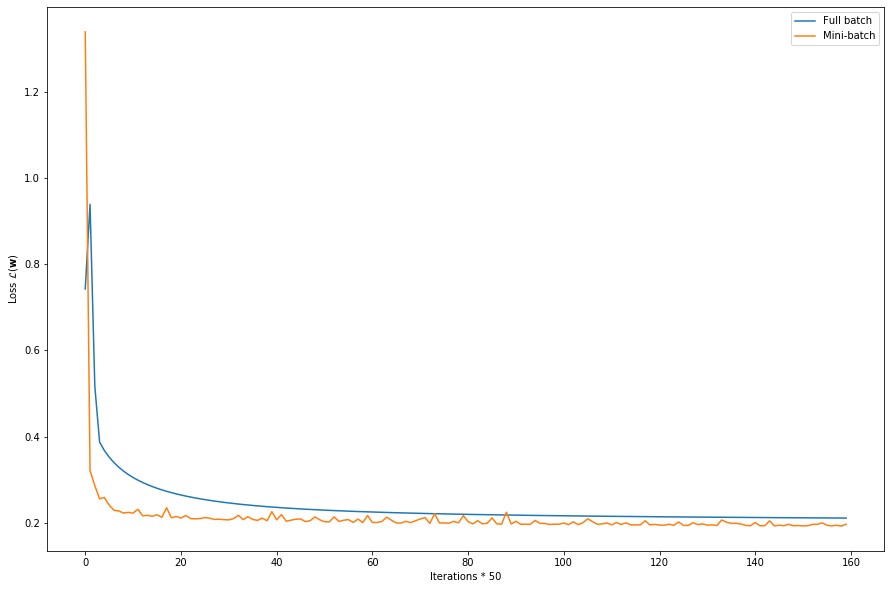

In [13]:
plt.figure(figsize=[15, 10])
plt.plot(trace_full, label='Full batch')
plt.plot(trace_minibatch, label='Mini-batch')
plt.xlabel('Iterations * 50')
plt.ylabel('Loss $\mathcal{L}(\mathbf{w})$')
plt.legend()
plt.show()